# Churn Project 

Data extracted from local CRM and DWH to calcutate tenure. This analysis will show the main reasons why contacts stoo using our server.

In [1]:
# libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import datetime
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from sklearn.model_selection import train_test_split
from causalnex.network import BayesianNetwork
import chart_studio.plotly as py
import cufflinks as cf
from lifelines import KaplanMeierFitter
cf.go_offline()
from causalnex.evaluation import classification_report

# Data Cleaning and Merge

# Process for Churn contacts
1.- HS churn contacts
2.- DWH churn contacts

In [2]:
## Cleaning data from HS (churn contacts): variables 
hs = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/mx-so-daily-churn-data.csv')
hs.head()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Profile Completeness - Percentage [Batch],Doctor - Specialisation 1 [Batch],Doctor - Verified [batch],Email Confirmed,First Name,Last Name,Contact owner,...,Doctor stats - Visits (booked by user) count [batch],Company ID,Name,Phone Number,City.1,Company owner,Last Activity Date,Country/Region,Industry,Create Date
0,58020208,No,no,75.0,Urólogo,1.0,NaN,Esteban,Velasco,Data Quality,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58020464,No,NaN,65.0,Cirujano general,1.0,NaN,Fernando,Vera Rodriguez,María del Carmen Curiel González,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58018941,No,NaN,65.0,Urólogo,1.0,NaN,Daniel,Nuño Diaz,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57991291,No,NaN,45.0,Psicólogo,1.0,NaN,María Soledad,Masuelli,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58020730,No,NaN,65.0,Psicólogo,1.0,NaN,Luis Fernando,Molina,Data Quality,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8271 entries, 0 to 8270
Data columns (total 54 columns):
Contact ID                                                               8271 non-null int64
Doctor - Has calendar [Batch]                                            8264 non-null object
Doctor - Has own website? (S) [Manual]                                   965 non-null object
Doctor - Profile Completeness - Percentage [Batch]                       8263 non-null float64
Doctor - Specialisation 1 [Batch]                                        8240 non-null object
Doctor - Verified [batch]                                                8264 non-null float64
Email Confirmed                                                          0 non-null float64
First Name                                                               8270 non-null object
Last Name                                                                8266 non-null object
Contact owner                                    

In [4]:
# dropping non relevant variables 
hs_clean = hs.drop(columns =['Create Date','Industry','Email Confirmed','Close Date',
         'Doctor - Onboarding Completed at (non commercial)',
        'Doctor - Gross Price of Premium Subscription - Currency type  [Batch]',
        'Doctor - Website - became customer at [batch]','Internal - Contact result [Manual]',
       'Doctor - Scoring at [WF]',' Doctor - Pre-onboarding completed at [Batch]',
        'Doctor - After first call at - Stage in the process [WF]','Doctor - Bought website service? [Batch]',
        'Doctor - Farming at - Lifecycle stage [WF]','Doctor - Farming at - Stage in the process [WF]',
        'Doctor - Onboarding at - Lifecycle stage [WF]','Doctor - Onboarding at - Lifecycle stage [WF]',
        'Doctor - Registration Phone Number [Batch]','Company ID','Company owner',])

In [5]:
# dropping variables with few data 
hs_clean.drop(columns = ['Doctor - Sold with website [Manual]',' Doctor - Pre-onboarding completed [Batch]',
               'Country/Region','Last Activity Date','City.1','Phone Number','Name',], inplace = True)

In [6]:
# Number of null contacts 
hs_clean.isna().sum()
hs_clean.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'Doctor - Verified [batch]',
       'First Name', 'Last Name', 'Contact owner', 'City', 'HubSpot Team',
       'Postal Code', 'Country [batch]', 'Doctor - Profile Scoring',
       'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]',
       'Doctor - Commercial from (last date) [Batch]',
       'Doctor sta

In [7]:
#Cleaning data from dhw (churn contacts):
dwh = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/batch0.csv')
dwh.head()

,root_object_id,hubspot_id,object_reference,name,product_type,commercial_from,last_commercial
0,2120701.0,161813141.0,doctor,Teresa TomÃ© Alvarado,Premium,2018-12-13T00:00:00+01:00,2019-01-13T00:00:00+01:00
1,2298265.0,148142853.0,doctor,Nadia Denise RodrÃ­guez Romo,Premium,2018-12-31T00:00:00+01:00,2019-01-30T00:00:00+01:00
2,2305233.0,162376441.0,doctor,Elizabeth PenÃ©lope RoldÃ¡n Alvarez,Premium,2018-09-30T00:00:00+02:00,2018-10-31T00:00:00+01:00
3,2249691.0,167775741.0,doctor,Suhaila Azuri Vallejo,Premium,2018-12-20T00:00:00+01:00,2019-01-20T00:00:00+01:00
4,3006107.0,146389555.0,doctor,JosÃ© Higinio PÃ©rez Gordillo,Premium,2018-04-10T00:00:00+02:00,2019-04-10T00:00:00+02:00


In [8]:
dwh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8696 entries, 0 to 8695
Data columns (total 7 columns):
root_object_id      8694 non-null float64
hubspot_id          8197 non-null float64
object_reference    8696 non-null object
name                8693 non-null object
product_type        8696 non-null object
commercial_from     8696 non-null object
last_commercial     8696 non-null object
dtypes: float64(2), object(5)
memory usage: 475.6+ KB


In [9]:
dwh['min_commercial_from'] = dwh.commercial_from.str[:10]
dwh['max_commercial_from'] = dwh.last_commercial.str[:10]

In [10]:
dwh_clean = dwh.drop(columns = ['commercial_from', 'last_commercial'])

In [11]:
# database shapes for merging function
print(hs_clean.shape, dwh_clean.shape)

(8271, 29) (8696, 7)


In [12]:
hs_dwh =pd.merge(hs_clean,dwh_clean, left_on = 'Contact ID', right_on = 'hubspot_id')
hs_dwh.shape

(6338, 36)

In [13]:
# HS data and Dwh data 
hs_dwh.drop(columns = ['Doctor - Verified [batch]','Postal Code'], inplace = True)
hs_dwh.head()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Profile Completeness - Percentage [Batch],Doctor - Specialisation 1 [Batch],First Name,Last Name,Contact owner,City,HubSpot Team,...,Doctor - Commercial [Batch],Doctor - Commercial from (last date) [Batch],Doctor stats - Visits (booked by user) count [batch],root_object_id,hubspot_id,object_reference,name,product_type,min_commercial_from,max_commercial_from
0,58020208,No,no,75.0,Urólogo,Esteban,Velasco,Data Quality,San Luis Potosi,Permission level 9,...,0,NaN,0.0,3007255.0,58020208.0,doctor,Esteban Velasco,Premium,2015-08-19,2019-01-18
1,58020464,No,NaN,65.0,Cirujano general,Fernando,Vera Rodriguez,María del Carmen Curiel González,Naucalpan de Juárez,MX_CS_FAR_1,...,0,NaN,0.0,3027203.0,58020464.0,doctor,Fernando Vera Rodriguez,Premium,2019-01-14,2019-02-13
2,58018941,No,NaN,65.0,Urólogo,Daniel,Nuño Diaz,NaN,Guadalajara,NaN,...,0,NaN,0.0,5646402.0,58018941.0,doctor,Daniel NuÃ±o Diaz,Premium,2017-05-18,2018-05-18
3,58020730,No,NaN,65.0,Psicólogo,Luis Fernando,Molina,Data Quality,Cuernavaca,Permission level 9,...,0,NaN,0.0,5872956.0,58020730.0,doctor,Luis Fernando Molina,Premium,2016-03-06,2016-10-14
4,58020711,No,NaN,81.0,Cirujano plástico,Juan Martín,Osorio del Ángel,María del Carmen Curiel González,Tampico,MX_CS_FAR_1,...,0,2019-03-08,0.0,6807376.0,58020711.0,doctor,Juan MartÃ­n Osorio del Ãngel,Premium,2016-01-28,2020-02-12


In [14]:
hs_dwh.shape

(6338, 34)

# Process for not-Churn Contacts
1.- HS not churn contacts
2.- DWH not churn contacts

In [15]:
# cleaning hs data, not churn contacts
hs1 = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/mx-so-batch-1.csv')
hs1.head()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Profile Completeness - Percentage [Batch],Doctor - Specialisation 1 [Batch],First Name,Last Name,Contact owner,HubSpot Team,Country [batch],...,Doctor stats - Visits (booked by user) count [batch],Company ID,Name,Phone Number,City,Company owner,Last Activity Date,Country/Region,Industry,Create Date
0,58015869,Yes,NaN,88.0,Cirujano general,Isabel Francisca,Manco Toro,Miguel Varela Cid,MX_CS_FAR_1,Mexico,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58016381,Yes,yes,91.0,Dentista - Odontólogo,Yazmin,Vivian Carlos,Francisco Flores González,MX_CS_FAR_1,Mexico,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58015871,Yes,yes,100.0,Cirujano pediátrico,Rene,Carmona Barba,Santiago Hernández Estrada,MX_CS_FAR_1,Mexico,...,9.0,2.342261e+09,hip-pospadias.com,55 4203 9589,CDMX,Jaqueline Sarai Lobaco Perez,2020-01-26 20:24,México,NaN,2019-08-20 20:03
3,58016357,Yes,NaN,99.0,Internista,Héctor Eduardo,Dueñas Silva,Jose Eduardo Vargas Bernal,MX_CS_FAR_1,Mexico,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57949541,Yes,NaN,93.0,Neurocirujano,Omar,Pichardo Uribe,Santiago Hernández Estrada,MX_CS_FAR_1,Mexico,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
hs1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10156 entries, 0 to 10155
Data columns (total 50 columns):
Contact ID                                                               10156 non-null int64
Doctor - Has calendar [Batch]                                            10154 non-null object
Doctor - Has own website? (S) [Manual]                                   3599 non-null object
Doctor - Profile Completeness - Percentage [Batch]                       10154 non-null float64
Doctor - Specialisation 1 [Batch]                                        10155 non-null object
First Name                                                               10156 non-null object
Last Name                                                                10150 non-null object
Contact owner                                                            10153 non-null object
HubSpot Team                                                             10153 non-null object
Country [batch]                      

In [17]:
# dropping non relevant variables 
hs1_clean = hs1.drop(columns =['Create Date','Industry','Close Date',
         'Doctor - Onboarding Completed at (non commercial)',
        'Doctor - Gross Price of Premium Subscription - Currency type  [Batch]',
        'Doctor - Website - became customer at [batch]','Internal - Contact result [Manual]',
       'Doctor - Scoring at [WF]',' Doctor - Pre-onboarding completed at [Batch]',
        'Doctor - After first call at - Stage in the process [WF]','Doctor - Bought website service? [Batch]',
        'Doctor - Farming at - Lifecycle stage [WF]','Doctor - Farming at - Stage in the process [WF]',
        'Doctor - Onboarding at - Lifecycle stage [WF]','Doctor - Onboarding at - Lifecycle stage [WF]',
        'Doctor - Registration Phone Number [Batch]','Company ID','Company owner',])

In [18]:
# dropping variables with few data 
hs1_clean.drop(columns = ['Doctor - Sold with website [Manual]',' Doctor - Pre-onboarding completed [Batch]',
               'Country/Region','Last Activity Date','Phone Number','Name',], inplace = True)

In [19]:
# Number of null contacts 
hs1_clean.isna().sum()
#hs1_clean.columns

Contact ID                                                 0
Doctor - Has calendar [Batch]                              2
Doctor - Has own website? (S) [Manual]                  6557
Doctor - Profile Completeness - Percentage [Batch]         2
Doctor - Specialisation 1 [Batch]                          1
First Name                                                 0
Last Name                                                  6
Contact owner                                              3
HubSpot Team                                               3
Country [batch]                                            0
Doctor - Profile Scoring                                   0
Doctor verified email [Batch]                             22
Doctor/Facility - Last Premium date [WF]                  15
Internal - Last Sales Owner [WF]                        2848
Internal - Sold by (DA)                                 3770
Doctor - Health Group [WF]                               252
Doctor - Last CS Owner [

In [20]:
#Cleaning data from dhw (churn contacts):
dwh1 = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/batch1.csv')
dwh1.head()

,root_object_id,hubspot_id,object_reference,name,product_type,commercial_from,last_commercial
0,2011121.0,142297441.0,doctor,Laura Gallardo,Premium,2018-02-19T00:00:00+01:00,2018-06-19T00:00:00+02:00
1,2184295.0,160237204.0,doctor,JesÃºs Rogelio Rojas GÃ³mez,Premium,2018-06-06T00:00:00+02:00,2019-02-06T00:00:00+01:00
2,2258165.0,168973868.0,doctor,Ernesto Garcilazo Murillo,Premium,2018-07-31T00:00:00+02:00,2019-01-31T00:00:00+01:00
3,2284923.0,174232856.0,doctor,AndrÃ©s Gracida Romero,Premium,2018-08-20T00:00:00+02:00,2019-02-15T00:00:00+01:00
4,2394811.0,188841988.0,doctor,Monica Quintero Ferrer,Premium,2018-11-06T00:00:00+01:00,2018-12-10T00:00:00+01:00


In [21]:
dwh1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17853 entries, 0 to 17852
Data columns (total 7 columns):
root_object_id      17849 non-null float64
hubspot_id          17238 non-null float64
object_reference    17851 non-null object
name                17848 non-null object
product_type        17853 non-null object
commercial_from     17851 non-null object
last_commercial     17851 non-null object
dtypes: float64(2), object(5)
memory usage: 976.4+ KB


In [22]:
dwh1['min_commercial_from'] = dwh1.commercial_from.str[:10]
dwh1['max_commercial_from'] = dwh1.last_commercial.str[:10]

In [23]:
dwh1_clean = dwh1.drop(columns = ['commercial_from', 'last_commercial'])

In [24]:
# database shapes for merging function
print(hs1_clean.shape, dwh1_clean.shape)

(10156, 27) (17853, 7)


In [25]:
hs1_dwh =pd.merge(hs1_clean,dwh1_clean, left_on = 'Contact ID', right_on = 'hubspot_id')
hs1_dwh.shape

(10124, 34)

In [26]:
print(hs_dwh.columns,hs1_dwh.columns)

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'City', 'HubSpot Team', 'Country [batch]',
       'Doctor - Profile Scoring', 'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]',
       'Doctor - Commercial from (last date) [Batch]',
       'Doctor stats - Visits (booked by user) count [batch]',
      

In [27]:
# reestructuring columns for not churn contacts database
hs1_dwh1 = hs1_dwh[['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'City', 'HubSpot Team', 'Country [batch]',
       'Doctor - Profile Scoring', 'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]',
       'Doctor - Commercial from (last date) [Batch]',
       'Doctor stats - Visits (booked by user) count [batch]',
       'root_object_id', 'hubspot_id', 'object_reference', 'name',
       'product_type', 'min_commercial_from', 'max_commercial_from']]

In [28]:
hs_dwh.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'City', 'HubSpot Team', 'Country [batch]',
       'Doctor - Profile Scoring', 'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]',
       'Doctor - Commercial from (last date) [Batch]',
       'Doctor stats - Visits (booked by user) count [batch]',
      

In [29]:
hs1_dwh1.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'City', 'HubSpot Team', 'Country [batch]',
       'Doctor - Profile Scoring', 'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]',
       'Doctor - Commercial from (last date) [Batch]',
       'Doctor stats - Visits (booked by user) count [batch]',
      

In [30]:
general = hs_dwh.append(hs1_dwh1, ignore_index= True)
general.tail()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Profile Completeness - Percentage [Batch],Doctor - Specialisation 1 [Batch],First Name,Last Name,Contact owner,City,HubSpot Team,...,Doctor - Commercial [Batch],Doctor - Commercial from (last date) [Batch],Doctor stats - Visits (booked by user) count [batch],root_object_id,hubspot_id,object_reference,name,product_type,min_commercial_from,max_commercial_from
16457,488362104,Yes,yes,93.0,Psicólogo,Laura,Albarrán Rendón,Paola Xareni Yañez Solis,NaN,MX_CS_ONB_1,...,1,2020-02-20,0.0,7287629.0,488362104.0,doctor,Laura AlbarrÃ¡n RendÃ³n,Premium,2020-02-20,2021-02-19
16458,488651720,Yes,no,83.0,Nutriólogo clínico,Victoria,Bernal Terán,Carlos Rodrigo Gonzalez Perez,NaN,MX_CS_ONB_1,...,1,2020-02-20,0.0,7287611.0,488651720.0,doctor,Victoria Bernal TerÃ¡n,Premium,2020-02-20,2020-03-19
16459,486167444,Yes,no,98.0,Neonatólogo,Daniel,Briceño Abraham,Paola Xareni Yañez Solis,NaN,MX_CS_ONB_1,...,1,2020-02-18,0.0,7287291.0,486167444.0,doctor,Daniel BriceÃ±o Abraham,Premium,2020-02-18,2021-02-17
16460,482447925,Yes,no,86.0,Otorrinolaringólogo,Laura,Espinosa Morett,Paola Xareni Yañez Solis,NaN,MX_CS_ONB_1,...,1,2020-02-18,0.0,7287029.0,482447925.0,doctor,Laura Espinosa Morett,Premium,2020-02-18,2020-03-17
16461,489489491,Yes,no,76.0,Ginecólogo,Marilyn J.,Quintana Baquedano,Sara Paola Mendoza Constantino,NaN,MX_CS_ONB_1,...,1,2020-02-20,0.0,7288019.0,489489491.0,doctor,Marilyn J. Quintana Baquedano,Premium,2020-02-20,2021-02-19


In [31]:
general.isna().sum()

Contact ID                                                  0
Doctor - Has calendar [Batch]                               0
Doctor - Has own website? (S) [Manual]                  12194
Doctor - Profile Completeness - Percentage [Batch]          0
Doctor - Specialisation 1 [Batch]                           9
First Name                                                  0
Last Name                                                   9
Contact owner                                            3224
City                                                    10012
HubSpot Team                                             3290
Country [batch]                                             0
Doctor - Profile Scoring                                    0
Doctor verified email [Batch]                             153
Doctor/Facility - Last Premium date [WF]                  229
Internal - Last Sales Owner [WF]                         3331
Internal - Sold by (DA)                                  6026
Doctor -

In [32]:
general['min_commercial_from']=pd.to_datetime(general['min_commercial_from'],format='%Y-%m-%d')
general['max_commercial_from']=pd.to_datetime(general['max_commercial_from'],format='%Y-%m-%d')

In [33]:
general['tenure'] = general['max_commercial_from'] - general['min_commercial_from']

In [34]:
import plotly.express as px
fig = px.histogram(general, x = 'tenure')
fig.show()

In [35]:
general_clean = general.fillna('-')

In [36]:
general_clean.isnull().sum()
general_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16462 entries, 0 to 16461
Data columns (total 35 columns):
Contact ID                                              16462 non-null int64
Doctor - Has calendar [Batch]                           16462 non-null object
Doctor - Has own website? (S) [Manual]                  16462 non-null object
Doctor - Profile Completeness - Percentage [Batch]      16462 non-null float64
Doctor - Specialisation 1 [Batch]                       16462 non-null object
First Name                                              16462 non-null object
Last Name                                               16462 non-null object
Contact owner                                           16462 non-null object
City                                                    16462 non-null object
HubSpot Team                                            16462 non-null object
Country [batch]                                         16462 non-null object
Doctor - Profile Scoring         

In [37]:
general_clean['Doctor - Profile Completeness - Percentage [Batch]']=Discretiser(method='fixed',
                             numeric_split_points=[1, 2]).transform(general_clean['Doctor - Profile Completeness - Percentage [Batch]'].values)
general_clean['Doctor - Profile Scoring']=Discretiser(method='fixed',
                             numeric_split_points=[1, 2]).transform(general_clean['Doctor - Profile Scoring'].values)
general_clean['Doctor stats - Visits (booked by user) count [batch]']=Discretiser(method='fixed',
                             numeric_split_points=[1, 2]).transform(general_clean['Doctor stats - Visits (booked by user) count [batch]'].values)
general_clean['root_object_id']=Discretiser(method='fixed',
                             numeric_split_points=[1, 2]).transform(general_clean['root_object_id'].values)
general_clean['hubspot_id']=Discretiser(method='fixed',
                             numeric_split_points=[1, 2]).transform(general_clean['hubspot_id'].values)


# CausalNex

CasualNex will be used to estimate if a customer becomes churn, based on the characteristics provided by local CRM.

In [38]:
sm = StructureModel()
sm

In [39]:
non_numeric_columns=list(general_clean.select_dtypes(exclude=[np.number]).columns)
non_numeric_columns

['Doctor - Has calendar [Batch]',
 'Doctor - Has own website? (S) [Manual] ',
 'Doctor - Specialisation 1 [Batch]',
 'First Name',
 'Last Name',
 'Contact owner',
 'City',
 'HubSpot Team',
 'Country [batch]',
 'Doctor verified email [Batch]',
 'Doctor/Facility - Last Premium date [WF]',
 'Internal - Last Sales Owner [WF]',
 'Internal - Sold by (DA)',
 'Doctor - Health Group [WF]',
 'Doctor - Last CS Owner [WF]',
 'Doctor - Onboarding owner (CX) [WF]',
 'Doctor - Stage in the process [WF]',
 'Doctor/Facility - Lifecycle stage [WF]',
 'Doctor/Facility - Onboarding type [WF/manual]',
 'Doctor/Facility - Payment method [Batch]',
 'Docplanner Category [batch]',
 'Doctor - Commercial from (last date) [Batch]',
 'object_reference',
 'name',
 'product_type',
 'min_commercial_from',
 'max_commercial_from']

In [40]:
le=LabelEncoder()

for col in non_numeric_columns:
    general_clean[col]=le.fit_transform(general_clean[col])

general_clean.head()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Profile Completeness - Percentage [Batch],Doctor - Specialisation 1 [Batch],First Name,Last Name,Contact owner,City,HubSpot Team,...,Doctor - Commercial from (last date) [Batch],Doctor stats - Visits (booked by user) count [batch],root_object_id,hubspot_id,object_reference,name,product_type,min_commercial_from,max_commercial_from,tenure
0,58020208,0,2,2,118,1998,13967,40,199,35,...,0,0,2,2,0,5017,0,213,712,1248 days
1,58020464,0,0,2,19,2122,14060,108,152,11,...,0,0,2,2,0,5395,0,1421,738,30 days
2,58018941,0,0,2,118,1375,9433,0,90,0,...,0,0,2,2,0,3550,0,822,475,365 days
3,58020730,0,0,2,102,4182,8597,40,76,35,...,0,0,2,2,0,10641,0,407,11,222 days
4,58020711,0,0,2,23,3633,9876,108,221,11,...,1541,0,2,2,0,9384,0,370,1098,1476 days


In [41]:
general_clean.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Profile Completeness - Percentage [Batch]',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'City', 'HubSpot Team', 'Country [batch]',
       'Doctor - Profile Scoring', 'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]',
       'Doctor - Commercial from (last date) [Batch]',
       'Doctor stats - Visits (booked by user) count [batch]',
      

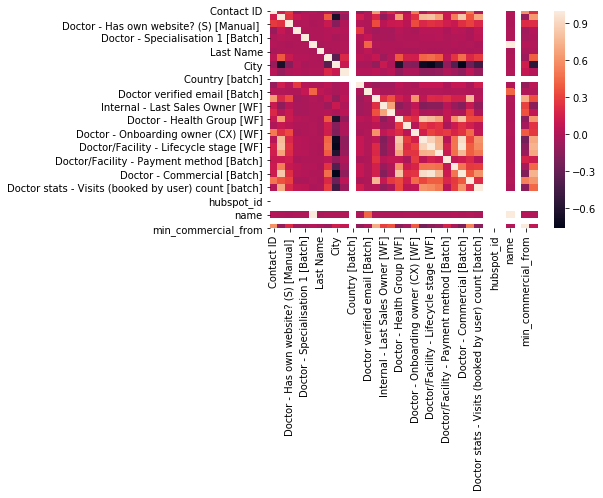

In [42]:
sns.heatmap(general_clean.corr())

In [43]:
#3general_clean.info()
general1 = general_clean.drop(columns = ['First Name', 
                                         'Last Name','Contact ID', 'Country [batch]', 
                                        'Doctor/Facility - Last Premium date [WF]', 'Doctor - Commercial from (last date) [Batch]',
                                        'root_object_id', 'hubspot_id', 'object_reference', 
                                         'name','product_type','min_commercial_from'
                                        ,'max_commercial_from', 'tenure','Doctor stats - Visits (booked by user) count [batch]',
                                        'Doctor - Profile Scoring','Doctor - Specialisation 1 [Batch]',
                                        'Doctor - Has own website? (S) [Manual] ','Doctor - Last CS Owner [WF]',
                                        'Doctor - Onboarding owner (CX) [WF]',
                                         'Doctor - Has calendar [Batch]','Doctor verified email [Batch]',
                                        'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)'])
sm=from_pandas(general1)

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



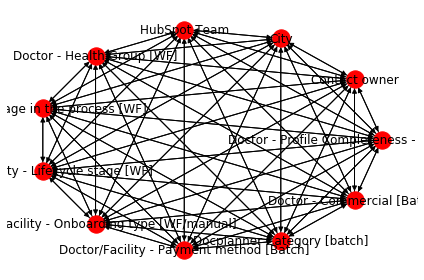

In [44]:
from causalnex.plots import plot_structure

fig, ax, nodes=plot_structure(sm)

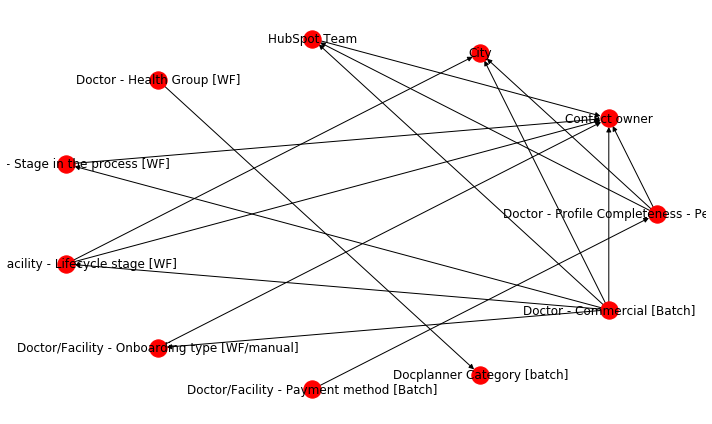

In [45]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
sm.remove_edges_below_threshold(.95)
fig , ax  , nodes = plot_structure(sm);

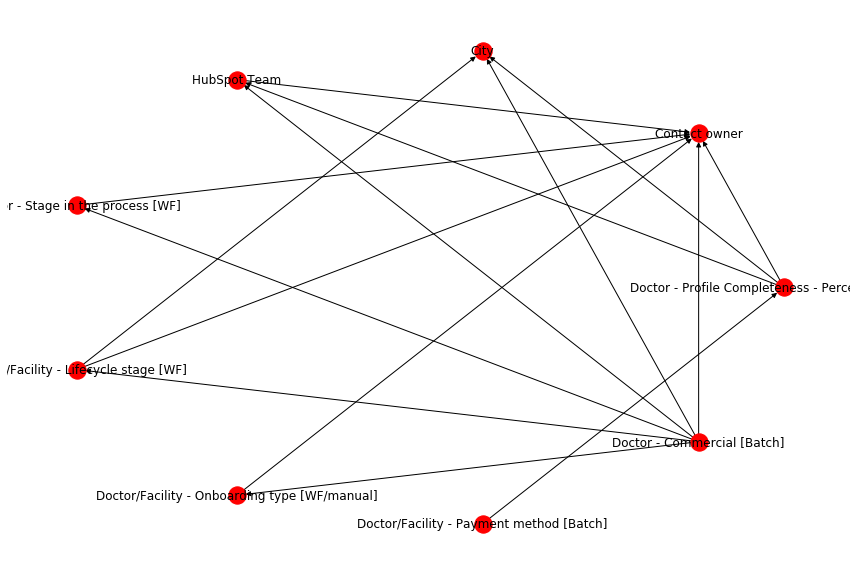

In [46]:
plt.rcParams['figure.figsize']=(12.0, 8.0)



sm=sm.get_largest_subgraph()

fig, ax, nodes=plot_structure(sm);


In [47]:
## Memory Optimization
for i in general1.select_dtypes('integer').columns:
    general1[i] = pd.to_numeric(general1[i], downcast = 'integer')
general1.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16462 entries, 0 to 16461
Data columns (total 11 columns):
Doctor - Profile Completeness - Percentage [Batch]    16462 non-null int8
Contact owner                                         16462 non-null int16
City                                                  16462 non-null int16
HubSpot Team                                          16462 non-null int8
Doctor - Health Group [WF]                            16462 non-null int8
Doctor - Stage in the process [WF]                    16462 non-null int8
Doctor/Facility - Lifecycle stage [WF]                16462 non-null int8
Doctor/Facility - Onboarding type [WF/manual]         16462 non-null int8
Doctor/Facility - Payment method [Batch]              16462 non-null int8
Docplanner Category [batch]                           16462 non-null int8
Doctor - Commercial [Batch]                           16462 non-null int8
dtypes: int16(2), int8(9)
memory usage: 209.1 KB


In [48]:
bn = BayesianNetwork(sm)

In [49]:
### Spliting Data for Bayesian net model
#gen = general1.sample(n = 10)
#train , test = train_test_split(gen, train_size = .8, test_size= .2, random_state = 42)

In [50]:

bn = bn.fit_node_states(general1)

In [52]:
bn = bn.fit_cpds(general1, method = 'BayesianEstimator', bayes_prior = 'K2' )

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5069: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5070: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.



In [53]:
bn.cpds['HubSpot Team']

Doctor - Commercial [Batch]                                0            \
Doctor - Profile Completeness - Percentage [Batch]         0         2   
HubSpot Team                                                             
0                                                   0.495238  0.513719   
1                                                   0.009524  0.000159   
2                                                   0.009524  0.001745   
3                                                   0.009524  0.000793   
4                                                   0.019048  0.001269   
5                                                   0.009524  0.000793   
6                                                   0.009524  0.000476   
7                                                   0.009524  0.001110   
8                                                   0.009524  0.000476   
9                                                   0.009524  0.001745   
10                                                  0.009524  0.001745   
11                                                  0.028571  0.074227   
12                                                  0.009524  0.000634   
13                                                  0.038095  0.008565   
14                                                  0.009524  0.000476   
15                                                  0.009524  0.000159   
16                                                  0.009524  0.008089   
17                                                  0.009524  0.007454   
18                                                  0.009524  0.016178   
19                                                  0.009524  0.001110   
20                                                  0.028571  0.006186   
21                                                  0.009524  0.006186   
22                                                  0.009524  0.003489   
23                                                  0.009524  0.001586   
24                                                  0.009524  0.001903   
25                                                  0.009524  0.002538   
26                                                  0.019048  0.004282   
27                                                  0.009524  0.001269   
28                                                  0.009524  0.003807   
29                                                  0.009524  0.000634   
30                                                  0.009524  0.002379   
31                                                  0.009524  0.001903   
32                                                  0.009524  0.000634   
33                                                  0.009524  0.000317   
34                                                  0.009524  0.000793   
35                                                  0.095238  0.321174   

Doctor - Commercial [Batch]                                1            
Doctor - Profile Completeness - Percentage [Batch]         0         2  
HubSpot Team                                                            
0                                                   0.011765  0.000198  
1                                                   0.011765  0.000198  
2                                                   0.011765  0.000099  
3                                                   0.011765  0.000297  
4                                                   0.011765  0.000099  
5                                                   0.011765  0.000099  
6                                                   0.011765  0.000099  
7                                                   0.011765  0.000099  
8                                                   0.011765  0.000099  
9                                                   0.011765  0.000099  
10                                                  0.023529  0.005637  
11                                                  0.411765  0.919593  
12                

In [ ]:
#predictions  = bn.predict(gen, 'Doctor - Commercial [Batch]')

In [ ]:
#classification_report(bn,test,'Doctor - Commercial [Batch]')

# Survival Method 

In [54]:
def survival(data, group_field, time_field, event_field):
    
    modelo=KaplanMeierFitter()
    
    res=[]
    for i in data[group_field].unique():
        grupo=data[data[group_field]==i]
        t=grupo[time_field]
        e=grupo[event_field]
        
        modelo.fit(t, e, label=str(i))
        
        res.append(modelo.survival_function_)
        
    survival=pd.concat(res, axis=1)
    return survival

In [55]:
general.tenure  =general.tenure.apply(lambda x: x.days)
general_clean.tenure = general_clean.tenure.apply(lambda x: x.days)

In [56]:
general_clean = general_clean[general_clean.tenure >0]
rates = survival(general_clean, 'Docplanner Category [batch]','tenure' , 'Doctor - Commercial [Batch]')

In [57]:
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retencion', title='Tasa de retencion por permanencia y categoría')

In [ ]:
rates = survival(general_clean, 'Doctor - Health Group [WF]','tenure' , 'Doctor - Commercial [Batch]')
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retencion', title='Tasa de retencion por permanencia y Health Group')

In [ ]:
rates = survival(general_clean, 'Doctor/Facility - Payment method [Batch]','tenure' , 'Doctor - Commercial [Batch]')
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retención', title='Tasa de retencion por permanencia y Método de Pago')


In [ ]:
rates = survival(general_clean, 'Contact owner','tenure' , 'Doctor - Commercial [Batch]')
rates.iplot(kind='line', xTitle='Permanencia días', 
            yTitle='Tasa de retención', title='Tasa de retencion por permanencia y Contact Owner')
